# 02 - For Blog Presentation...

In [1]:
%matplotlib inline

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
# Read in the meta info and target variables
labels = pd.read_csv('../TRAIN/track_parms.csv')
labels = labels.rename(columns={'phi': 'theta'})
labels[['filename', 'theta', 'z']].tail()

,filename,theta,z
499995,img499995.png,-4.509653,0.968584
499996,img499996.png,-1.595661,-7.397094
499997,img499997.png,7.695264,-2.984060
499998,img499998.png,-1.898667,5.082713
499999,img499999.png,4.275843,-2.266920


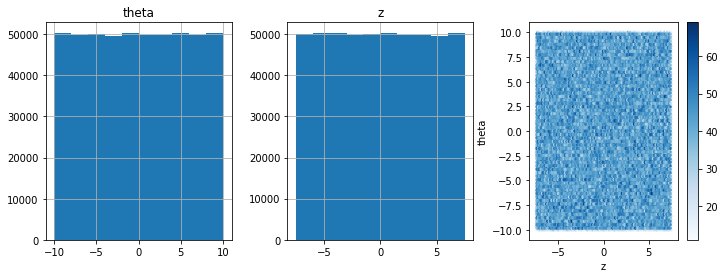

In [65]:
# What do our distributions look like?
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(12, 4))
labels[['theta', 'z']].hist(ax=[ax0, ax1])
labels.plot(x='z', y='theta', kind='hexbin',
            sharex=False, cmap="Blues", ax=ax2)

## Create Data Generator

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Activation, MaxPooling2D,
    Flatten, Dense, Dropout
)

height = 100
width = 36
channels = 3

In [67]:
def multiclass_classifier():
    model = Sequential()

    # Convolution Layer
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [68]:
# Bin the theta values to get multi-class labels
labels['theta_binned'], theta_bins = pd.cut(labels['theta'],
                                            bins=range(-10, 12, 2),
                                            retbins=True)
labels['theta_binned'] = labels['theta_binned'].astype(str)
labels[['filename', 'theta', 'theta_binned']].tail()

,filename,theta,theta_binned
499995,img499995.png,-4.509653,"(-6, -4]"
499996,img499996.png,-1.595661,"(-2, 0]"
499997,img499997.png,7.695264,"(6, 8]"
499998,img499998.png,-1.898667,"(-2, 0]"
499999,img499999.png,4.275843,"(4, 6]"


In [56]:
datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.25)

n_subsample = 10000
batch_size = 32

train_gen = datagen.flow_from_dataframe(
    dataframe=labels.head(n_subsample),
    directory="../TRAIN",
    x_col="filename",
    y_col="theta_binned",
    subset="training",
    target_size=(height, width),
    batch_size=batch_size,
    seed=314,
    shuffle=False,
    class_mode="categorical",
)

val_gen = datagen.flow_from_dataframe(
    dataframe=labels.head(n_subsample),
    directory="../TRAIN",
    x_col="filename",
    y_col="theta_binned",
    subset="validation",
    target_size=(height, width),
    batch_size=batch_size,
    seed=314,
    shuffle=False,
    class_mode="categorical",
)

Found 7500 validated image filenames belonging to 10 classes.
Found 2500 validated image filenames belonging to 10 classes.


In [57]:
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VAL = val_gen.n//val_gen.batch_size

In [30]:
classifier = multiclass_classifier()
clf_history = classifier.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val_gen,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

Epoch 1/10
234/234 [==============================] - 10s 44ms/step - loss: 0.1840 - accuracy: 0.9493 - val_loss: 0.0483 - val_accuracy: 0.9796
Epoch 2/10
234/234 [==============================] - 9s 37ms/step - loss: 0.0811 - accuracy: 0.9720 - val_loss: 0.0400 - val_accuracy: 0.9832
Epoch 3/10
234/234 [==============================] - 9s 37ms/step - loss: 0.0596 - accuracy: 0.9776 - val_loss: 0.0342 - val_accuracy: 0.9860
Epoch 4/10
234/234 [==============================] - 8s 36ms/step - loss: 0.0539 - accuracy: 0.9798 - val_loss: 0.0395 - val_accuracy: 0.9832
Epoch 5/10
234/234 [==============================] - 9s 38ms/step - loss: 0.0483 - accuracy: 0.9802 - val_loss: 0.0420 - val_accuracy: 0.9836
Epoch 6/10
234/234 [==============================] - 9s 39ms/step - loss: 0.0446 - accuracy: 0.9842 - val_loss: 0.0285 - val_accuracy: 0.9892
Epoch 7/10
234/234 [==============================] - 8s 34ms/step - loss: 0.0400 - accuracy: 0.9851 - val_loss: 0.0356 - val_accuracy: 0.982

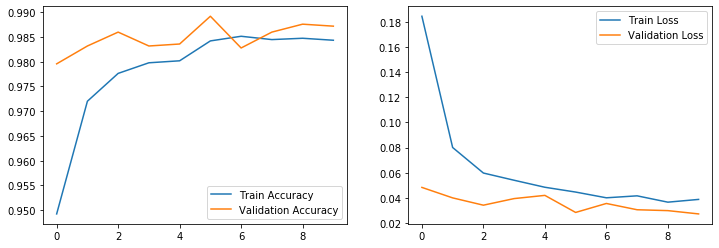

In [31]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(12, 4))
plt.sca(ax0)
plt.plot(clf_history.history['accuracy'],
         label="Train Accuracy")
plt.plot(clf_history.history['val_accuracy'],
         label="Validation Accuracy")
plt.legend()
plt.sca(ax1)
plt.plot(clf_history.history['loss'],
         label="Train Loss")
plt.plot(clf_history.history['val_loss'],
         label="Validation Loss")
plt.legend()
plt.show()

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

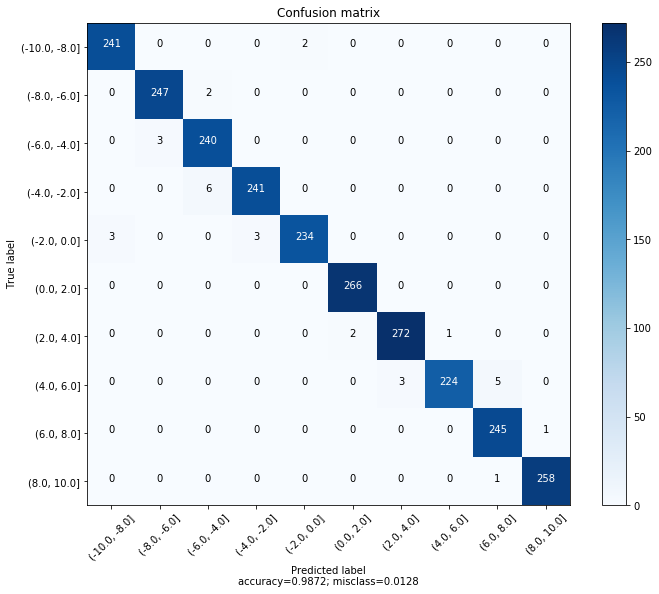

In [63]:
y_pred = classifier.predict_classes(val_gen)
y_true = val_gen.labels

label_list = ['(-10.0, -8.0]', '(-8.0, -6.0]', '(-6.0, -4.0]', '(-4.0, -2.0]',
              '(-2.0, 0.0]', '(0.0, 2.0]', '(2.0, 4.0]', '(4.0, 6.0]', '(6.0, 8.0]',
              '(8.0, 10.0]']
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      target_names=label_list,
                      normalize=False)

# Double Regression

In [73]:
def double_regression_model():
    model = Sequential()

    # Convolution Layer
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
    
    return model

In [70]:
n_subsample = 100000
batch_size = 32

train_gen = datagen.flow_from_dataframe(
    dataframe=labels.head(n_subsample),
    directory="../TRAIN",
    x_col="filename",
    y_col=["z", "theta"],
    subset="training",
    target_size=(height, width),
    batch_size=batch_size,
    seed=314,
    shuffle=False,
    class_mode="other",
)

val_gen = datagen.flow_from_dataframe(
    dataframe=labels.head(n_subsample),
    directory="../TRAIN",
    x_col="filename",
    y_col=["z", "theta"],
    subset="validation",
    target_size=(height, width),
    batch_size=batch_size,
    seed=314,
    shuffle=False,
    class_mode="other",
)

Found 75000 validated image filenames.
Found 25000 validated image filenames.


In [71]:
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VAL = val_gen.n//val_gen.batch_size

In [74]:
regressor = double_regression_model()
reg_history = regressor.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val_gen,
    validation_steps=STEP_SIZE_VAL,
    epochs=10
)

Epoch 1/10
2343/2343 [==============================] - 93s 40ms/step - loss: 5.2578 - mse: 5.2578 - val_loss: 2.4976 - val_mse: 2.4976
Epoch 2/10
2343/2343 [==============================] - 93s 40ms/step - loss: 3.8986 - mse: 3.8984 - val_loss: 1.7813 - val_mse: 1.7813
Epoch 3/10
2343/2343 [==============================] - 86s 37ms/step - loss: 3.6461 - mse: 3.6460 - val_loss: 1.8129 - val_mse: 1.8129
Epoch 4/10
2343/2343 [==============================] - 80s 34ms/step - loss: 3.5189 - mse: 3.5187 - val_loss: 1.5009 - val_mse: 1.5009
Epoch 5/10
2343/2343 [==============================] - 77s 33ms/step - loss: 3.3984 - mse: 3.3983 - val_loss: 1.5923 - val_mse: 1.5923
Epoch 6/10
2343/2343 [==============================] - 84s 36ms/step - loss: 3.2987 - mse: 3.2987 - val_loss: 1.3894 - val_mse: 1.3894
Epoch 7/10
2343/2343 [==============================] - 86s 37ms/step - loss: 3.1830 - mse: 3.1829 - val_loss: 1.1961 - val_mse: 1.1961
Epoch 8/10
2343/2343 [==========================

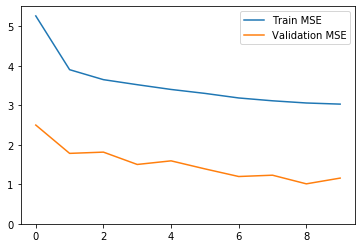

In [79]:
plt.plot(reg_history.history['mse'],
         label="Train MSE")
plt.plot(reg_history.history['val_mse'],
         label="Validation MSE")
plt.ylim([0, 5.5])
plt.legend()
plt.show()

In [73]:
def deep_double_regression_model():
    model = Sequential()

    # Convolution Layer
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
    
    return model